In [12]:
%%capture
from helpers import *
import sys
import jupyter
sys.meta_path.append(NotebookFinder())
import main

# from model.modules.cadCAD import *
import model.config as config

# cadCAD Modelling

## Statistical distribution of investment

In [13]:
import matplotlib.pyplot as plt
from scipy.stats import poisson
import seaborn as sns

sns.set(color_codes=True)
sns.set(rc={'figure.figsize':(4.5,3)})

227.64430394801298
5355.603281274876
1076008.3021787882


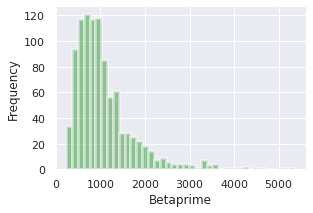

In [14]:
import numpy as np
from scipy.stats import betaprime

# Source: https://stackoverflow.com/questions/37559470/what-do-all-the-distributions-available-in-scipy-stats-look-like

data_betaprime = betaprime.rvs(a=5.00, loc=100.00, scale=1000.00, b=6.00, size=1000)
ax = sns.distplot(data_betaprime,
                  kde=False,
                  color='green',
                  hist_kws={"linewidth": 3})
ax.set(xlabel='Betaprime', ylabel='Frequency')

print(min(data_betaprime))
print(max(data_betaprime))
print(sum(data_betaprime))

distribution_chunks = np.array_split(data_betaprime, config.timesteps)
def get_distribution_point(x):
    return sum(distribution_chunks[x])

## Model configuration

In [ ]:
from enum import Enum, auto
class Pool(Enum):
    reserve = auto()
    investment = auto()
    
class Edge(Enum):
    balance = auto()
    
def add_node(network, node):
    network.add_node(node.name, _type=node.__class__.__name__)

def initialize_network():
    logger.info('Initializing network')
    network = nx.Graph()
    color_map = []
    
    add_node(network, Pool.reserve)
    add_node(network, Pool.investment)
    
    return (network, color_map)
    
def network_genesis(network, _params, state):
    logger.info('Network genesis')
    initial_supply = _params['']
    
    
    return network

In [ ]:
def sweep_range(params):
    max_len = 1
    for key in params:
        param_length = len(params[key])
        if param_length > max_len:
            max_len = param_length
    return list(range(1, max_len + 1)) or [1] 

parameters: Dict[str, List[int]] = {
    'initial_raise': [3e6],
    'premine': [3e6],
    'kappa': [4],
    'P0': [1],
#     'investor_contribution_distribution': [
#         get_distribution_point
#     ],
#     'user_contribution_distribution': [
#         get_distribution_point
#     ],
}

parameters['sweep'] = sweep_range(params)

initial_state = {
    'genesis': False,
    'invariant': 0,
    'total_investment': 0,
    'available_investment': 0,
    'token_supply': 0,
    'reserve_pool': 0,
    'policies': {},
}

In [ ]:
network, color_map = initialize_network()

pos = nx.drawing.nx_agraph.graphviz_layout(network, prog='dot')

plt.figure()
nx.draw(
    network, pos, edge_color='black', width=2, linewidths=1,
    node_size=800, node_color='pink', alpha=0.9,
    labels={node: node for node in network.nodes()})

nx.draw_networkx_edge_labels(
    network, pos,
    edge_labels={(u,v): d['_type'] for u,v,d in network.edges(data=True)},
    font_color='red')

plt.axis('off')
plt.show()

initial_state.update({
    'network': network,
})

In [ ]:
def check_genesis(_params, step, sL, s):
    genesis = False
    if s['timestep'] == 0:
        logger.info('Genesis')
        genesis = True
        
    return ({'genesis': genesis})

def perform_genesis(_params, step, sL, s, _input):
    network = s['network']
    
    genesis = _input['genesis']
    if genesis:
        logging.info('Perform genesis')
        network = network_genesis(network, _params, s)
        
    return ('network', network)

In [ ]:
import pprint
from typing import Dict, List

import pandas as pd
from tabulate import tabulate

from cadCAD.configuration import append_configs
from cadCAD.configuration.utils import config_sim
from cadCAD.engine import ExecutionMode, ExecutionContext, Executor
from cadCAD import configs

pp = pprint.PrettyPrinter(indent=4)

# Policies
def investor_contribution(_params, step, sH, s):
    #contribution = _params['investor_contribution_distribution'](step)
    contribution = 
    return {'investor_contribution': contribution}

def user_contribution(_params, step, sH, s):
    #contribution = _params['user_contribution_distribution'](step)
    return {'user_contribution': contribution}

# Internal States
def reserve_ratio(_params, step, sH, s, _input):
    return 'invariant', _params['invariant']

def update_investment(_params, step, sH, s, _input):
    return 'total_investment', s['total_investment'] + _input['investor_contribution']

def update_reserve_pool(_params, step, sH, s, _input):
    _params['primitive_function']()
    return 'reserve_pool', s['reserve_pool'] + _input['investor_contribution']

sim_configs = config_sim(
    {
        'N': config.runs,
        'T': config.timesteps,
        'M': parameters,
    }
)

partial_state_update_blocks = [
    { # Genesis
        'policies': {
            'genesis': check_genesis,
        },
        'variables': {
            'network': perform_genesis,
        }
    },
    {
        'policies': {
            'investor_contribution': investor_contribution
        },
        'variables': {
            'reserve_pool': update_reserve_pool,
            'total_investment': update_investment
        }
    },
    {
        'policies': {
            'user_contribution': user_contribution
        },
        'variables': {
        }
    },
]

append_configs(
    sim_configs=sim_configs,
    initial_state=initial_state,
    #env_processes=env_process,
    partial_state_update_blocks=partial_state_update_blocks
)

exec_mode = ExecutionMode()
local_proc_ctx = ExecutionContext(context=exec_mode.local_mode)
run = Executor(exec_context=local_proc_ctx, configs=configs)

i = 0
verbose = False
results = {}
for raw_result, tensor_field in run.execute():
    result = pd.DataFrame(raw_result)
    if verbose:
        print()
        print(f"Tensor Field: {type(tensor_field)}")
        print(tabulate(tensor_field, headers='keys', tablefmt='psql'))
        print(f"Output: {type(result)}")
        print(tabulate(result, headers='keys', tablefmt='psql'))
        print()
    results[i] = {}
    results[i]['result'] = result
    results[i]['simulation_parameters'] = sim_configs[i]
    i += 1